In [1]:
import os
import numpy as np
import logging
import time
from collections import Counter
import math
import random

import hdbscan
from pathlib import Path
from hdbscan import validity
from sklearn.manifold import TSNE
from tqdm import tqdm
from joblib import Parallel, delayed

import multiprocessing as mp
import matplotlib.pyplot as plt
from shutil import copyfile

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
now_times = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())


In [24]:
protein_pdb = "/mnt/nas1/lanwei-125/FGF5/dock_prepare/FGF5.pdb"
peptide_pdb_dir = "/mnt/nas1/lanwei-125/FGF5/disf_ADCP_best_pose_pdb/"
cluster_path = "/mnt/nas1/lanwei-125/FGF5/test/"

protein_pdb = Path(protein_pdb)
peptide_pdb_dir = Path(peptide_pdb_dir)
cluster_path = Path(cluster_path)
peptide_number = 50

DBCV_score_vs_trials = cluster_path / "DBCV_score_vs_trials.png"
cluster_result = cluster_path / "cluster_result.txt"
point_plot = cluster_path / "cluster_point_plot.png"

HPEP = False  # if your structures are from HPEP, set it to True, else set it to False
ADCP = False  # if your structures are from ADCP, set it to True, else set it to False
contact_cutoff = 7  # 6 angstroms

In [3]:
protein_coords = []
with open(protein_pdb) as f:
    for line in f:
        if line.startswith("ATOM"):
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            protein_coords.append([x, y, z])
logger.info(f"Read protein {len(protein_coords)} atom coordinates from target PDB file.")


2023-12-20 10:01:45,836 - INFO - Read protein 2091 atom coordinates from target PDB file.


In [4]:
peptide_coords = []
peptide_names = []
for pdb_path in Path(peptide_pdb_dir).glob("*.pdb"):
    coords = []
    with open(pdb_path) as f:
        for line in f:
            if line.startswith("ATOM"):
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                coords.append([x, y, z])
    peptide_coords.append(coords)
    peptide_names.append(pdb_path.stem)
    
logger.info(f'{now_times}: read {len(peptide_coords)} peptides')


2023-12-20 10:01:47,818 - INFO - 2023-12-20 10:01:44: read 234 peptides


In [5]:
def calc_contacts(peptide_idx, peptide_coords, protein_coords, contact_cutoff):
    """
    Calculate the number of contacts between a peptide and a protein.

    Parameters:
    - peptide_idx (int): The index of the peptide in the list of peptide coordinates.
    - peptide_coords (list): A list of lists containing the coordinates of each peptide.
    - protein_coords (list): A list containing the coordinates of the protein.
    - contact_cutoff (float): The distance threshold for considering a contact.

    Returns:
    - dists (list): A list containing the number of contacts for each protein coordinate.
    """
    dists = [0] * len(protein_coords)
    for p_idx, p_coord in enumerate(protein_coords):
        contact = 0
        for pe_coord in peptide_coords[peptide_idx]:
            dist = np.linalg.norm(np.array(p_coord) - np.array(pe_coord))
            if dist < contact_cutoff:
                contact += 1
        dists[p_idx] = contact
 
    return dists

In [6]:
contact_matrices = []
with mp.Pool() as pool:
    results = [
        pool.apply_async(
            calc_contacts, args=(i, peptide_coords, protein_coords, contact_cutoff)
        )
        for i in range(len(peptide_coords))
    ]
    contact_matrices = [r.get() for r in results]
logger.info(f'{now_times} contact_matrices length: {len(contact_matrices)}')

2023-12-20 10:02:01,879 - INFO - 2023-12-20 10:01:44 contact_matrices length: 234


In [7]:
contact_matrixs = []
for dists in contact_matrices:
    contact_matrixs.append(dists)
contact_matrixs = np.array(contact_matrixs)

logger.info(f"contact_matrices length: {len(contact_matrices)}")

2023-12-20 10:02:03,669 - INFO - contact_matrices length: 234


100%|██████████| 45/45 [00:00<00:00, 156.25it/s]


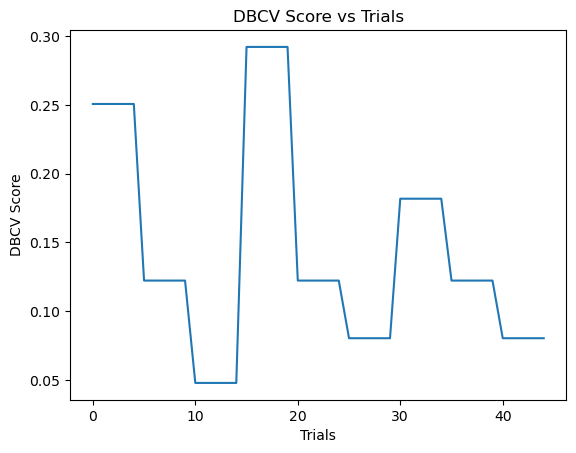

2023-12-20 10:02:13,801 - INFO - 2023-12-20 10:01:44 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=3, min_samples=2), Score: 0.2922494197972452


In [8]:

scores = {}

def run_hdbscan(params):
    min_cluster_size, min_samples, eps, cluster_selection_method = params
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=eps,
        cluster_selection_method=cluster_selection_method,
        gen_min_span_tree=True,
        core_dist_n_jobs=-1,
    ).fit(contact_matrixs)
    score = hdb.relative_validity_
    return hdb, score

min_cluster_sizes = list(range(2, 5))
min_samples_values = list(range(2, 5))
eps_values = [x * 0.1 for x in range(1, 30, 2)]
cluster_selection_methods = [
    "eom", 
    #"leaf"
    ]

param_combinations = [
    (min_cluster_size, min_samples, eps, cluster_selection_method)
    for min_cluster_size in min_cluster_sizes
    for min_samples in min_samples_values
    for eps in eps_values
    for cluster_selection_method in cluster_selection_methods
]

results = Parallel(n_jobs=-1)(
    delayed(run_hdbscan)(params) for params in tqdm(param_combinations)
)


for hdb, score in results:
    scores[hdb] = score

plt.plot(list(range(len(scores))), scores.values())
plt.xlabel("Trials")
plt.ylabel("DBCV Score")
plt.title("DBCV Score vs Trials")
plt.show()
#plt.savefig(DBCV_score_vs_trials)

best_model = max(scores, key=scores.get)

logger.info(f"{now_times} Best Model: {best_model}, Score: {scores[best_model]}")

In [9]:
'''
hdb = hdbscan.HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=2, min_samples=2).fit(contact_matrixs)
'''
hdb=best_model.fit(contact_matrices)
labels = hdb.labels_
score = hdb.relative_validity_
logger.info(f'{now_times} Best Model: {best_model}, Score: {score}')

2023-12-20 10:02:17,017 - INFO - 2023-12-20 10:01:44 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=3, min_samples=2), Score: 0.2922494197972452


In [10]:
cluster_keys = {}
for label in set(labels):
    tabel = int(label)
    cluster_keys[label] = []
for i, label in enumerate(labels):
    cluster_keys[label].append(peptide_names[i])
for label in sorted(cluster_keys):
    with open(cluster_result, "a+") as f:
        f.write(
            f"Cluster {label}:{cluster_keys[label]}\n {len(cluster_keys[label])}\n"
        )
logger.info(f"{now_times} Cluster information saved to {cluster_result}")

2023-12-20 10:02:23,136 - INFO - 2023-12-20 10:01:44 Cluster information saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_result.txt


2023-12-20 10:02:26,505 - INFO - 2023-12-20 10:01:44 2D t-SNE plot saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_point_plot.png


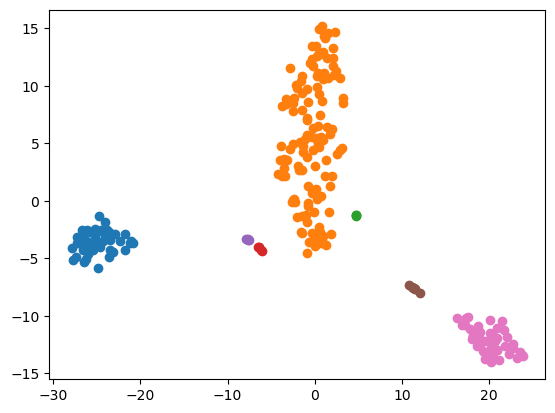

In [11]:
tsne = TSNE()
X_tsne = tsne.fit_transform(contact_matrixs)
fig, ax = plt.subplots()
for i in range(len(cluster_keys)):
    ax.scatter(
        X_tsne[labels == i, 0],
        X_tsne[labels == i, 1],
    )
plt.savefig(point_plot)
logger.info(f"{now_times} 2D t-SNE plot saved to {point_plot}")

In [12]:

# 定义函数extract_random_peptides，用于从每个集群中提取随机肽段
# 参数cluster_keys：每个集群的键
# 参数random_peptides：每个集群中要提取的随机肽段数量
def extract_random_peptides(cluster_keys, random_peptides):
    # 创建一个字典real_cluster，用于存储每个集群的键和值
    real_cluster = {}
    # 遍历cluster_keys，将每个集群的键和值存入real_cluster中
    for i in range(0,len(cluster_keys)-1):
        a= cluster_keys[i]
        real_cluster[i] = a 

    # 计算每个集群中肽段的数量
    total_peptides = sum(len(peptides) for peptides in real_cluster.values())
    # 计算每个集群中每个肽段的权重
    weights = {label: len(peptides) / total_peptides for label, peptides in real_cluster.items()}
    # 计算每个集群中要提取的随机肽段数量
    peptides_to_extract = {label: math.ceil(random_peptides * weight) for label, weight in weights.items()}

    # 创建一个字典selected_peptides，用于存储每个集群中提取的随机肽段
    selected_peptides = {}
    # 遍历real_cluster，从每个集群中提取指定数量的随机肽段
    for label, peptides in real_cluster.items():
        selected_peptides[label] = random.sample(peptides, peptides_to_extract[label])
        
    # 计算提取的随机肽段的总数量
    real_random_peptides = sum(len(peptides) for peptides in selected_peptides.values())
    # 输出日志信息
    logger.info(f"{now_times} {real_random_peptides} peptides are randomly selected")
    # 返回提取的随机肽段
    return selected_peptides

selected_peptides = extract_random_peptides(cluster_keys, peptide_number)
selected_peptides






2023-12-20 10:02:30,794 - INFO - 2023-12-20 10:01:44 52 peptides are randomly selected


{0: ['CYIVQCLLG',
  'CYIQECKLG',
  'CPIGNC',
  'GSCSGAFCPRSI',
  'CHPAKTVC',
  'CPSDKPPC',
  'CKPDGPPC',
  'GKCHAAFCFRRD',
  'CPVDKPQC',
  'CTDKNCPLG'],
 1: ['CTSESDC',
  'CNGTEC',
  'CQTESC',
  'CYSFECPLG',
  'CPSDKC',
  'ACIAEYACMY',
  'CKNGKCPLG',
  'CPSDKCPLG',
  'SECEMCPDK',
  'CYIQHCEVG',
  'CDKEMCPLG',
  'CTPEDC',
  'CYILPCVDV',
  'CTNKPESC',
  'CVLNHVSC',
  'CNSNCPQLG',
  'CTSQKDC',
  'CSEKTC',
  'SCAINNCPM',
  'CSLEQCPLR',
  'CTNQEC',
  'CHEYGSPC',
  'CYIIECNLG',
  'CNNINTPCGG',
  'CTKEDDCPK',
  'CTSNEPDC',
  'GSCFGAMCKKRD'],
 2: ['CTEDKDC'],
 3: ['CRYATC'],
 4: ['GSCFGAFCAGVD'],
 5: ['CTKPSEC', 'CHPHIEVC'],
 6: ['CTTKEPESC',
  'CESIMTWADC',
  'CEIEWCTM',
  'GSCFGAFCYSDP',
  'DCGAMICYEY',
  'CYIIGCYLG',
  'CEEIGPWTLC',
  'CYNEYCPLG',
  'CTQEDC',
  'DQCMLPGCE']}

In [16]:


def score_cluster(HDB_cluster_dict, peptide_pdb_dir, HPEP, ADCP, peptide_number):
    
    min_scores = {}
    total_peptides = sum(len(peptides) for peptides in HDB_cluster_dict.values())
    weights = {label: len(peptides) / total_peptides for label, peptides in HDB_cluster_dict.items()}
    peptides_to_extract = {label: math.ceil(peptide_number * weight) for label, weight in weights.items()}

    for label, peptides in HDB_cluster_dict.items():
        min_score_peptides = []
        peptides.sort(key=lambda peptide: get_score(peptide, peptide_pdb_dir, HPEP, ADCP))
        min_score_peptides = peptides[:peptides_to_extract[label]]
        min_scores[label] = min_score_peptides

    count = 0
    for label, peptides in min_scores.items():
        count += len(peptides)

    logger.info(f"{now_times} {count} peptides are selected from all cluster")
    
    return min_scores

# Function to get the score of a peptide from the pdb file
def get_score(peptide, peptide_pdb_dir, HPEP, ADCP):
    pdb_file = Path(peptide_pdb_dir) / f"{peptide}.pdb"
    with open(pdb_file) as f:
        for line in f:
            if HPEP:
                score_marker = "REMARK ITScore"
            elif ADCP:
                score_marker = "REMARK SCORE"
            else:
                break
            if line.startswith(score_marker):
                return float(line.split()[-1])





# Usage
peptide_number = 70
ADCP = True
HPEP = False
selected_peptides = score_cluster(cluster_keys, peptide_pdb_dir, HPEP, ADCP, peptide_number)
selected_peptides

2023-12-20 10:05:52,683 - INFO - 2023-12-20 10:01:44 75 peptides are selected from all cluster


{0: ['EKCLGAFCFRRD',
  'GSCFDKECFRRD',
  'CYIQECKLG',
  'GKCHAAFCFRRD',
  'SSCFQPFCFRRD',
  'CYIQVCLGG',
  'CYIVQCLLG',
  'CTDKNCPLG',
  'CYWTSCPLG',
  'SCANINCGL',
  'CYATWCPLG',
  'CNSINCPLG',
  'CHPGGYKC',
  'CTWSNCPLG'],
 1: ['GSCTDAECFRRD',
  'SCKECMLMD',
  'MYCEYAYACS',
  'GSCFGAMCKKRD',
  'CEQIWTEKC',
  'CYIQHCEVG',
  'CYIIECNLG',
  'CTDKECPLG',
  'CSFEFC',
  'CDKEMC',
  'ACIAEYACMY',
  'CYINVCFLG',
  'CKEMEC',
  'CYIHLCNLG',
  'CYIQNCIGG',
  'CYIQVCILG',
  'CTDQKDC',
  'SECEMCPDK',
  'DCETCPKL',
  'CYIQLCVLG',
  'CTKEDDCPK',
  'CTEDKC',
  'CTSESDC',
  'CYIGSCVLG',
  'CDDNPKEC',
  'CTEKSC',
  'CHPIQWLC',
  'CDKEMCPLG',
  'CHEYGSPC',
  'CTEKQDPC',
  'CYIQQCTLG',
  'CIELPWMCI',
  'CTSKEDC',
  'CHPAGEYC',
  'CTKPEENC',
  'CTDPMEPEC',
  'CTDKEC',
  'CYILPCVDV'],
 2: ['CTEDKDC'],
 3: ['CTPMEKEC', 'CRYATC'],
 4: ['GSCFNSICFRRD', 'GSCFGAFCAGVD'],
 5: ['GSCPHIFCFRRD', 'CSEDCPLK', 'CNEPGCNLG'],
 6: ['ECAEEYCMY',
  'ESCIEWTECL',
  'ECSMLWTCES',
  'EECIWCMTL',
  'ACEIWGCTEL',
  'CEMAEYMYC'

In [31]:
cluster_label_pdbs = []
cluster_laber_tags = []
for cluster_labels_keys in selected_peptides.keys():
    cluster_laber_tags.append(int(cluster_labels_keys))
    cluster_label_pdbs.append(selected_peptides[cluster_labels_keys])
    #print(cluster_labels_keys, selected_peptides[cluster_labels_keys],len(selected_peptides[cluster_labels_keys]))

for cluster_label_pdb, cluster_laber_tag in zip(cluster_label_pdbs, cluster_laber_tags):
    #print(cluster_label_pdb, cluster_laber_tag)
    cluster_dir = Path(cluster_path) / f"cluster_{cluster_laber_tag}"

    if not cluster_dir.exists():
        cluster_dir.mkdir(parents=True, exist_ok=True)
        
    for peptide in cluster_label_pdb:
        original_pdb = Path(peptide_pdb_dir) / f"{peptide}.pdb"
        clustered_pdb = cluster_dir / f"{peptide}.pdb"

        #判断二硫键
        with open(original_pdb) as f:
            lines = f.readlines()
        sg_atoms = [line for line in lines if line.startswith('ATOM') and line[21] == "E" and line[12:16].strip() == 'SG']
        if len(sg_atoms) == 2:
            x1, y1, z1 = [float(sg_atoms[0][30:38]), float(sg_atoms[0][38:46]), float(sg_atoms[0][46:54])]
            x2, y2, z2 = [float(sg_atoms[1][30:38]), float(sg_atoms[1][38:46]), float(sg_atoms[1][46:54])]
            dist = ((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2) ** 0.5

            if not clustered_pdb.exists() and dist < 2.5:
                print(clustered_pdb)
                copyfile(original_pdb, clustered_pdb)

'''
        if not clustered_pdb.exists():
            copyfile(original_pdb, clustered_pdb)
'''            

/mnt/nas1/lanwei-125/FGF5/test/cluster_0/GSCFDKECFRRD.pdb
/mnt/nas1/lanwei-125/FGF5/test/cluster_1/CYIQVCILG.pdb
/mnt/nas1/lanwei-125/FGF5/test/cluster_1/CTDQKDC.pdb
/mnt/nas1/lanwei-125/FGF5/test/cluster_1/DCETCPKL.pdb
/mnt/nas1/lanwei-125/FGF5/test/cluster_1/CTEDKC.pdb
/mnt/nas1/lanwei-125/FGF5/test/cluster_1/CTEKSC.pdb
/mnt/nas1/lanwei-125/FGF5/test/cluster_2/CTEDKDC.pdb
/mnt/nas1/lanwei-125/FGF5/test/cluster_6/ESCIEWTECL.pdb
/mnt/nas1/lanwei-125/FGF5/test/cluster_6/CEMAEYMYC.pdb
/mnt/nas1/lanwei-125/FGF5/test/cluster_6/FECEAMYCY.pdb


'\n        if not clustered_pdb.exists():\n            copyfile(original_pdb, clustered_pdb)\n'

In [18]:
cluster_label_pdbs = []
cluster_laber_tags = []
for cluster_labels_keys in cluster_keys.keys():
    cluster_laber_tags.append(int(cluster_labels_keys))
    cluster_label_pdbs.append(cluster_keys[cluster_labels_keys])

for cluster_label_pdb, cluster_laber_tag in zip(cluster_label_pdbs, cluster_laber_tags):
    out_file = Path(cluster_path) / f"{cluster_laber_tag}.pdb"
    i = 0
    for pdb in cluster_label_pdb:
        pdb_file = Path(peptide_pdb_dir) / f"{pdb}.pdb"
        with open(out_file, "a") as f_out, open(pdb_file) as f_in:
            i = i + 1
            f_out.write(f"\nMODEL {i}\n")
            # Filter out MODEL/END/ENDMDL lines
            lines = [
                line
                for line in f_in
                if "MODEL" not in line
                and "END" not in line
                and "ENDMDL" not in line
            ]
            f_out.write("".join(lines))
            f_out.write(f_in.read())
            f_out.write("END\n")
            f_out.write("ENDMDL\n\n")    
logger.info(f"{now_times} Clustered PDB files saved to {cluster_path}")

2023-12-20 10:06:06,798 - INFO - 2023-12-20 10:01:44 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
